In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import * 
from tensorflow.keras.applications.vgg19 import VGG19
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow_addons as tfa

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "figure.figsize" : (10,10),
          "axes.titlecolor" : 'w'}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
image_size = (128,128)
batch_size = 32

In [5]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale',
                                           batch_size=batch_size)

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


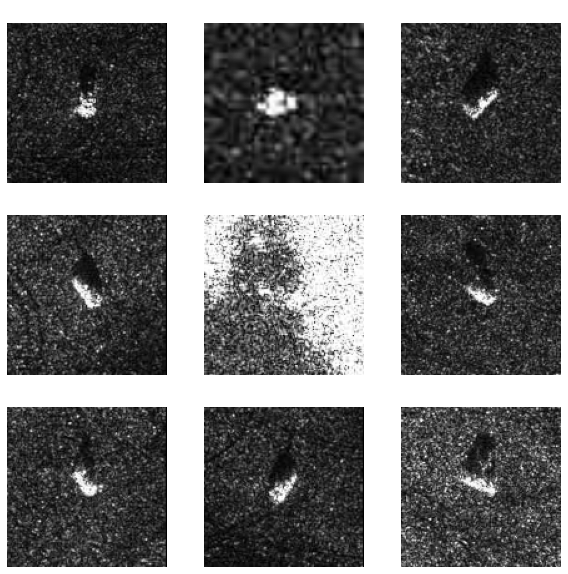

In [6]:
class_names = train_ds.class_names
with plt.rc_context(params):
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
      plt.title(class_names[np.argmax(labels[i])], )
      plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 54
Number of test batches: 13


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes=9

metrics = [
      keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tfa.metrics.MatthewsCorrelationCoefficient(num_classes=9, name='MCC'),
      tfa.metrics.FBetaScore(num_classes=9, average='weighted', beta=2.0, name='F2'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'),
]

In [10]:
model1 = keras.Sequential()

model1.add(InputLayer(input_shape=(image_size + (1,))))

model1.add(Flatten())

model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))
model1.add(Dense(100, activation='relu'))

model1.add(Dense(num_classes, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1638500   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 1,659,609
Trainable params: 1,659,609
Non-trainable params: 0
_________________________________________________________________


In [11]:
model1.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)

In [12]:
history1 = model1.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 6s 12ms/step - loss: 65.2887 - categorical_accuracy: 0.4206 - MCC: 0.3445 - F2: 0.4191 - auc: 0.7120 - prc: 0.3180 - val_loss: 4.5429 - val_categorical_accuracy: 0.5455 - val_MCC: 0.5145 - val_F2: 0.5060 - val_auc: 0.8129 - val_prc: 0.4819
Epoch 2/10
265/265 [==============================] - 3s 10ms/step - loss: 2.4534 - categorical_accuracy: 0.7232 - MCC: 0.6870 - F2: 0.7225 - auc: 0.9064 - prc: 0.7172 - val_loss: 0.7700 - val_categorical_accuracy: 0.8180 - val_MCC: 0.7964 - val_F2: 0.8120 - val_auc: 0.9686 - val_prc: 0.8903
Epoch 3/10
265/265 [==============================] - 3s 11ms/step - loss: 0.6829 - categorical_accuracy: 0.8555 - MCC: 0.8366 - F2: 0.8555 - auc: 0.9718 - prc: 0.9022 - val_loss: 1.8237 - val_categorical_accuracy: 0.7816 - val_MCC: 0.7640 - val_F2: 0.7714 - val_auc: 0.9316 - val_prc: 0.7933
Epoch 4/10
265/265 [==============================] - 3s 10ms/step - loss: 0.9863 - categorical_accuracy: 0.8307 - MCC: 

In [13]:
def holdout_results(model):
    result = model.evaluate(test_ds)
    return dict(zip(model.metrics_names, result))
    

In [14]:
def plot_metrics(history):
  with plt.rc_context(params):    
    metrics = ['loss', 'prc', 'F2', 'MCC']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      elif metric == 'auc':
        plt.ylim([0.8,1])
      elif metric == 'MCC':
        plt.ylim([-1,1])
      else:
        plt.ylim([0,1])

      plt.legend();

In [15]:
def plot_cm(model, data):
    with plt.rc_context(params):
        y_true = []
        y_pred = []
        for x,y in data:
            y= tf.argmax(y,axis=1)
            y_true.append(y)
            y_pred.append(tf.argmax(model.predict(x),axis = 1))
    
        y_pred = tf.concat(y_pred, axis=0)
        y_true = tf.concat(y_true, axis=0)

        cm = confusion_matrix(y_true, y_pred)
        fig = plt.figure(figsize = (10,10))
        ax1 = fig.add_subplot(1,1,1)
        sns.set(font_scale=1.4) #for label size
        sns.heatmap(cm,cmap='binary', annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 10},
            cbar = False);
        ax1.set_ylabel('True Values',fontsize=14)
        ax1.set_xlabel('Predicted Values',fontsize=14)
        plt.show()

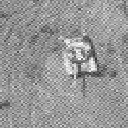

In [16]:
image = keras.utils.load_img(
    path="C:\\Users\\nated\\Documents\\GitHub\\sar_target_recognition_deep_learning\\holdout_imgs\\t72_kuwait.jpg",
    color_mode='grayscale',
    target_size=(128,128)
)

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

image

In [17]:
def predict_t72(model):
    predictions = model.predict(image_array)
    score = tf.nn.softmax(predictions[0])
    return(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

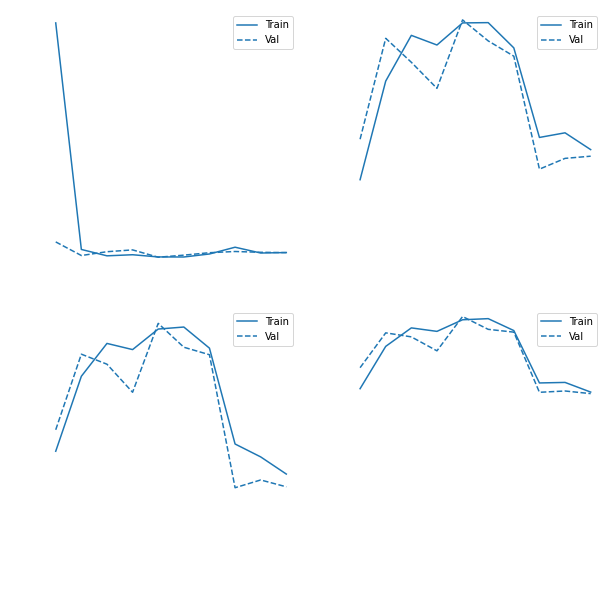

In [18]:
plot_metrics(history1)

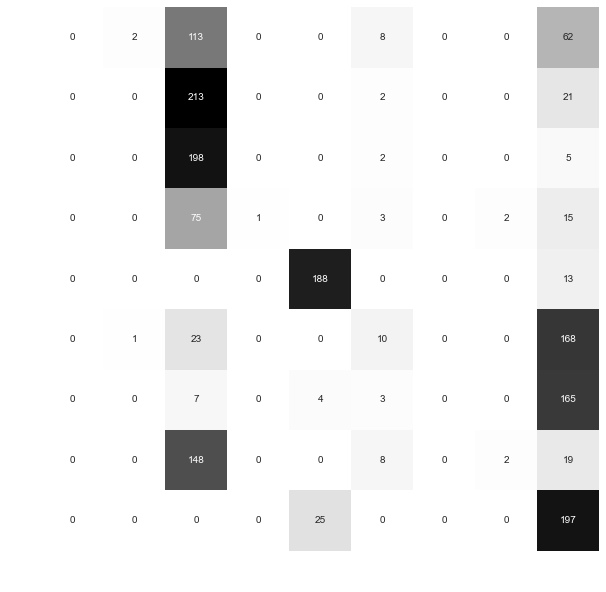

In [19]:
plot_cm(model1, val_ds)

In [20]:
holdout_results(model1)

13/13 [==============================] - 0s 16ms/step - loss: 1.5086 - categorical_accuracy: 0.3606 - MCC: 0.3139 - F2: 0.2857 - auc: 0.8340 - prc: 0.4328


{'loss': 1.5086416006088257,
 'categorical_accuracy': 0.36057692766189575,
 'MCC': 0.3138890862464905,
 'F2': 0.28567758202552795,
 'auc': 0.8340238332748413,
 'prc': 0.432785302400589}

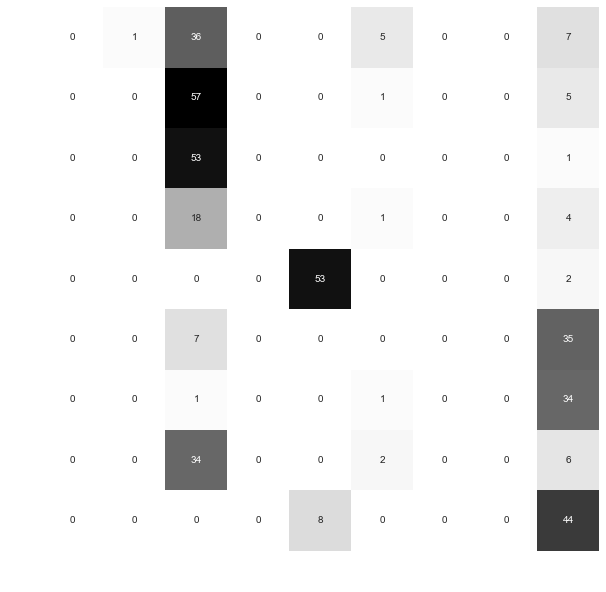

In [21]:
plot_cm(model1, test_ds)

In [22]:
predict_t72(model1)

'This image most likely belongs to BTR_60 with a 12.30 percent confidence.'

In [23]:
model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (1,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)       

In [24]:
model2.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=metrics)


In [25]:
history2 = model2.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 7s 18ms/step - loss: 0.9304 - categorical_accuracy: 0.6576 - MCC: 0.6135 - F2: 0.6533 - auc: 0.9409 - prc: 0.7715 - val_loss: 0.2461 - val_categorical_accuracy: 0.9243 - val_MCC: 0.9151 - val_F2: 0.9235 - val_auc: 0.9961 - val_prc: 0.9766
Epoch 2/10
265/265 [==============================] - 4s 15ms/step - loss: 0.1428 - categorical_accuracy: 0.9566 - MCC: 0.9509 - F2: 0.9566 - auc: 0.9983 - prc: 0.9914 - val_loss: 0.0819 - val_categorical_accuracy: 0.9753 - val_MCC: 0.9724 - val_F2: 0.9752 - val_auc: 0.9990 - val_prc: 0.9963
Epoch 3/10
265/265 [==============================] - 4s 15ms/step - loss: 0.0720 - categorical_accuracy: 0.9792 - MCC: 0.9765 - F2: 0.9792 - auc: 0.9994 - prc: 0.9969 - val_loss: 0.0635 - val_categorical_accuracy: 0.9777 - val_MCC: 0.9750 - val_F2: 0.9776 - val_auc: 0.9997 - val_prc: 0.9980
Epoch 4/10
265/265 [==============================] - 4s 15ms/step - loss: 0.0519 - categorical_accuracy: 0.9861 - MCC: 0

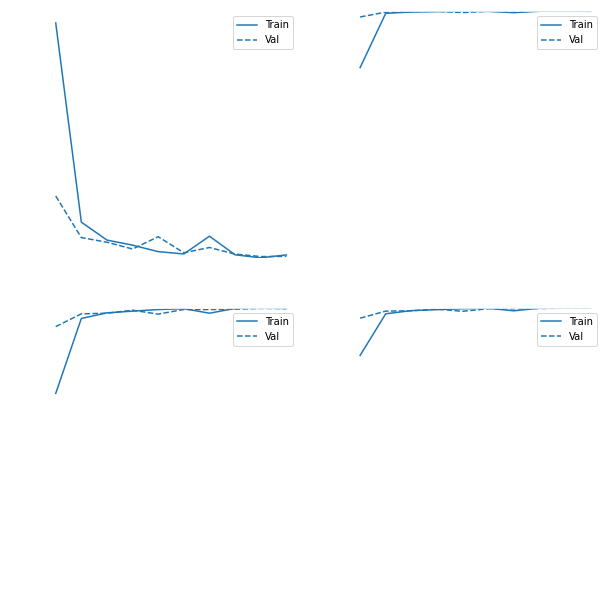

In [26]:
plot_metrics(history2)

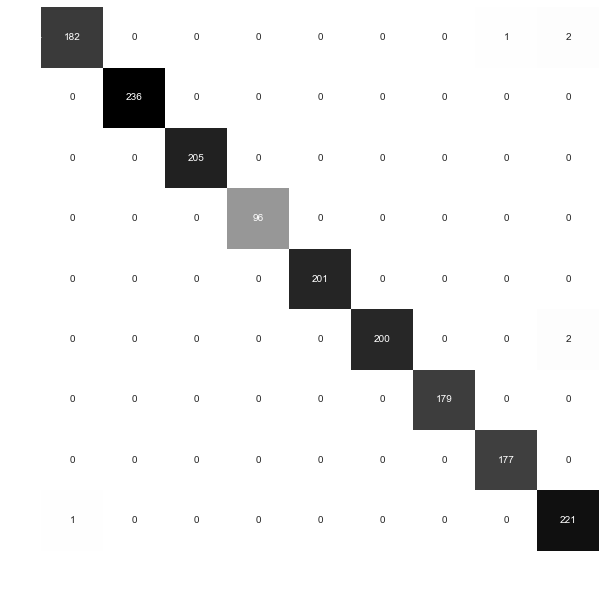

In [27]:
plot_cm(model2, val_ds)

In [28]:
holdout_results(model2)

13/13 [==============================] - 0s 10ms/step - loss: 0.0109 - categorical_accuracy: 0.9928 - MCC: 0.9918 - F2: 0.9928 - auc: 1.0000 - prc: 0.9999


{'loss': 0.01086580753326416,
 'categorical_accuracy': 0.9927884340286255,
 'MCC': 0.9918333292007446,
 'F2': 0.9927730560302734,
 'auc': 0.9999934434890747,
 'prc': 0.9999482035636902}

In [29]:
predict_t72(model2)

'This image most likely belongs to 2S1 with a 25.28 percent confidence.'

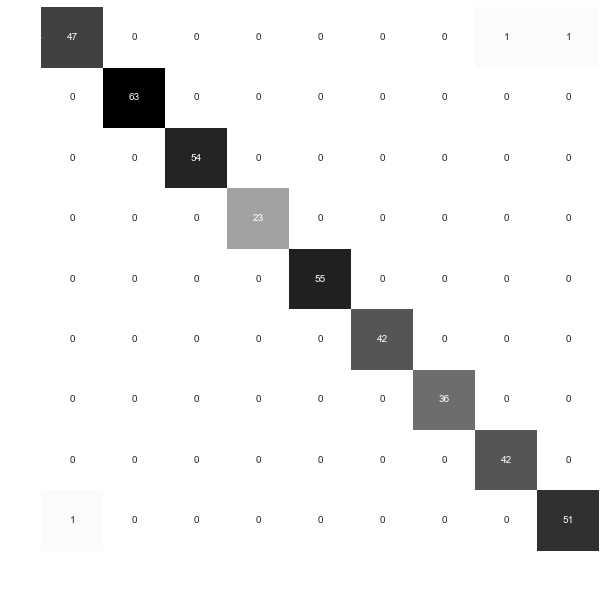

In [30]:
plot_cm(model2, test_ds)

In [31]:
CNN = Sequential()
CNN.add(InputLayer(input_shape=(image_size + (1,))))
CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=20, kernel_size=3, activation='relu', padding='same'))
CNN.add(MaxPooling2D())
CNN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
CNN.add(GlobalAveragePooling2D())
CNN.add(Dense(20, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 20)        1820      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 30)        5430      
_________________________________________________________________
global_average_pooling2d (Gl (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)               

In [32]:
CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [33]:
cnn_hist = CNN.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
265/265 [==============================] - 6s 18ms/step - loss: 1.9433 - categorical_accuracy: 0.3775 - MCC: 0.3080 - F2: 0.3522 - auc: 0.7817 - prc: 0.4247 - val_loss: 1.2001 - val_categorical_accuracy: 0.5414 - val_MCC: 0.5141 - val_F2: 0.5005 - val_auc: 0.9097 - val_prc: 0.6713
Epoch 2/10
265/265 [==============================] - 5s 17ms/step - loss: 1.0236 - categorical_accuracy: 0.6098 - MCC: 0.5645 - F2: 0.5926 - auc: 0.9359 - prc: 0.7275 - val_loss: 1.0054 - val_categorical_accuracy: 0.6142 - val_MCC: 0.5958 - val_F2: 0.5899 - val_auc: 0.9363 - val_prc: 0.7005
Epoch 3/10
265/265 [==============================] - 3s 13ms/step - loss: 0.7177 - categorical_accuracy: 0.7248 - MCC: 0.6914 - F2: 0.7141 - auc: 0.9690 - prc: 0.8414 - val_loss: 0.5080 - val_categorical_accuracy: 0.7904 - val_MCC: 0.7667 - val_F2: 0.7782 - val_auc: 0.9864 - val_prc: 0.9097
Epoch 4/10
265/265 [==============================] - 3s 13ms/step - loss: 0.5701 - categorical_accuracy: 0.7652 - MCC: 0

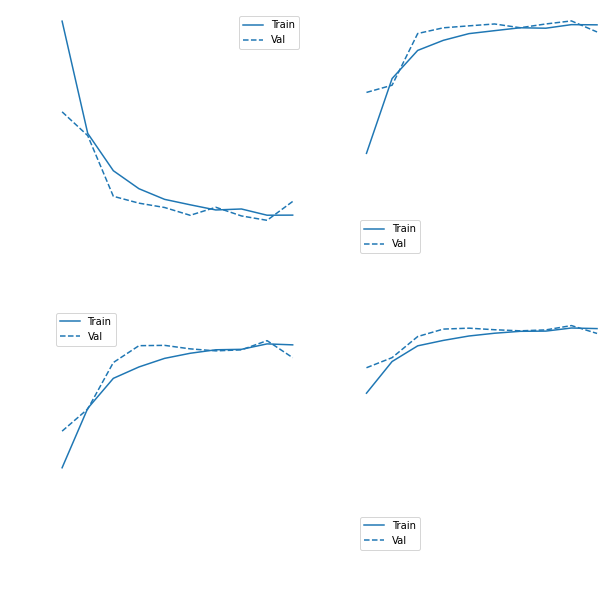

In [34]:
plot_metrics(cnn_hist)

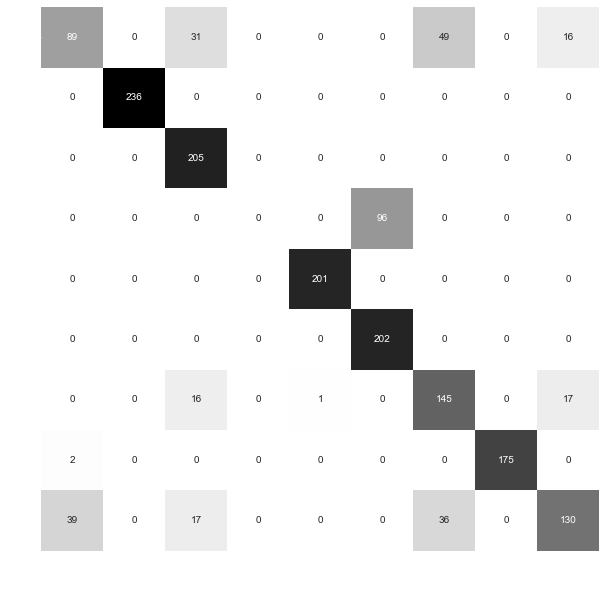

In [35]:
plot_cm(CNN, val_ds)

In [36]:
holdout_results(CNN)

13/13 [==============================] - 0s 8ms/step - loss: 0.5062 - categorical_accuracy: 0.8029 - MCC: 0.7808 - F2: 0.7881 - auc: 0.9825 - prc: 0.9074


{'loss': 0.5061601400375366,
 'categorical_accuracy': 0.8028846383094788,
 'MCC': 0.7808059453964233,
 'F2': 0.7881139516830444,
 'auc': 0.9824963212013245,
 'prc': 0.9073565006256104}

In [38]:
predict_t72(CNN)

'This image most likely belongs to T72 with a 24.72 percent confidence.'

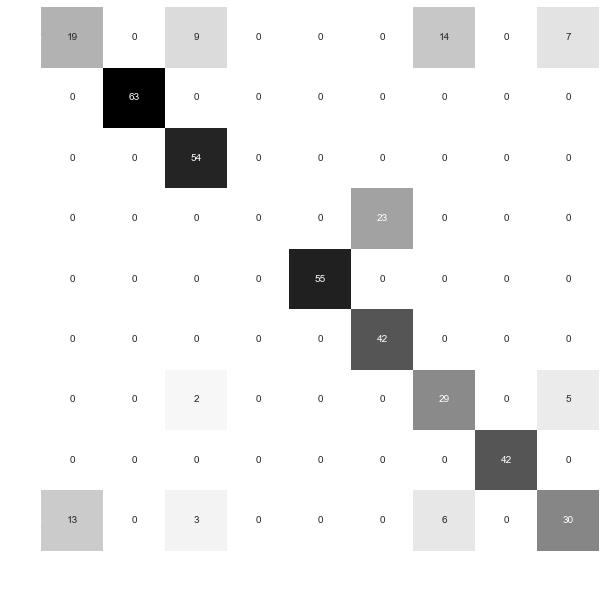

In [39]:
plot_cm(CNN, test_ds)

In [40]:
resize_and_rescale = tf.keras.Sequential([
  keras.layers.Resizing(128,128),
  keras.layers.Rescaling(1./255)])

In [41]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.1),
    ]
)

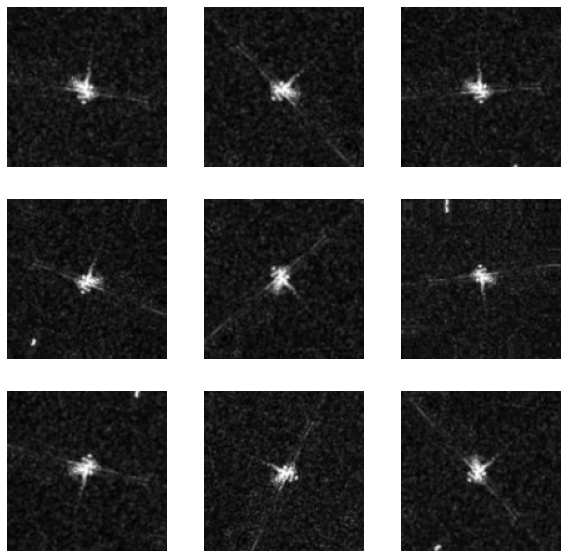

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"), cmap='gray')
        plt.axis("off")

In [43]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = resize_and_rescale(inputs)
    x = data_augmentation(x)

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


xception = make_model(input_shape=image_size + (1,), num_classes=9)
xception.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 128, 128, 1)  0           input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 128, 128, 1)  0           sequential_3[0][0]               
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 32)   320         sequential_4[0][0]               
______________________________________________________________________________________________

In [44]:
callbacks=[
        keras.callbacks.EarlyStopping(patience=10, verbose=1, monitor='val_F2', mode='max', restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
xception.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,
)
xception_hist = xception.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 31s 106ms/step - loss: 1.1540 - categorical_accuracy: 0.5855 - MCC: 0.5308 - F2: 0.5839 - auc: 0.9199 - prc: 0.6743 - val_loss: 5.6136 - val_categorical_accuracy: 0.1039 - val_MCC: 0.0000e+00 - val_F2: 0.0382 - val_auc: 0.5026 - val_prc: 0.1106
Epoch 2/100
265/265 [==============================] - 23s 85ms/step - loss: 0.5479 - categorical_accuracy: 0.8026 - MCC: 0.7768 - F2: 0.8027 - auc: 0.9796 - prc: 0.8921 - val_loss: 7.1702 - val_categorical_accuracy: 0.1151 - val_MCC: 0.0580 - val_F2: 0.0525 - val_auc: 0.6025 - val_prc: 0.1668
Epoch 3/100
265/265 [==============================] - 21s 79ms/step - loss: 0.3825 - categorical_accuracy: 0.8636 - MCC: 0.8458 - F2: 0.8637 - auc: 0.9898 - prc: 0.9413 - val_loss: 12.9709 - val_categorical_accuracy: 0.2572 - val_MCC: 0.2580 - val_F2: 0.1965 - val_auc: 0.6036 - val_prc: 0.1846
Epoch 4/100
265/265 [==============================] - 23s 86ms/step - loss: 0.2762 - categorical_accuracy: 0

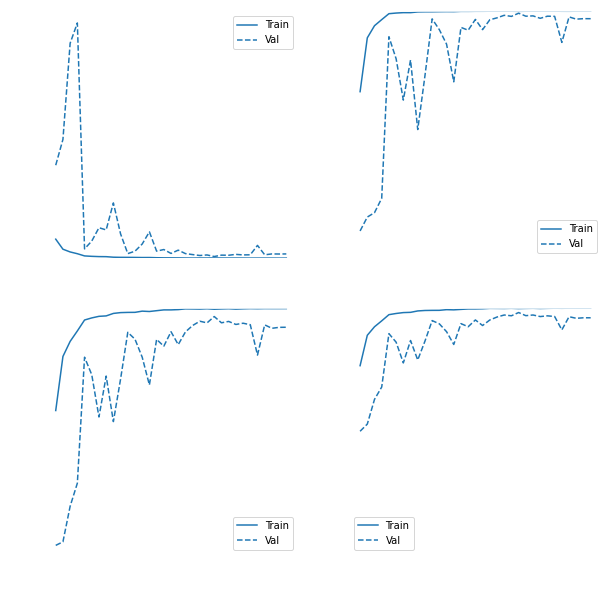

In [45]:
plot_metrics(xception_hist)

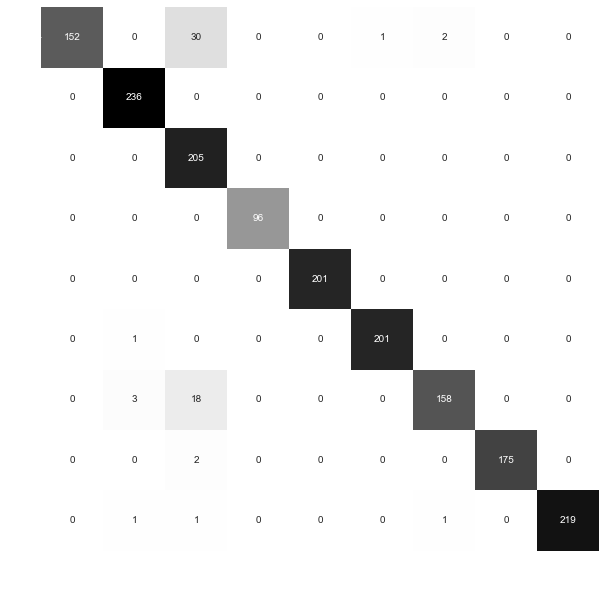

In [46]:
plot_cm(xception, val_ds)

In [47]:
holdout_results(xception)

13/13 [==============================] - 0s 27ms/step - loss: 0.1073 - categorical_accuracy: 0.9663 - MCC: 0.9627 - F2: 0.9657 - auc: 0.9979 - prc: 0.9904


{'loss': 0.10734844207763672,
 'categorical_accuracy': 0.9663461446762085,
 'MCC': 0.9627001285552979,
 'F2': 0.9657373428344727,
 'auc': 0.9979223608970642,
 'prc': 0.9904272556304932}

In [48]:
predict_t72(xception)

'This image most likely belongs to 2S1 with a 24.31 percent confidence.'

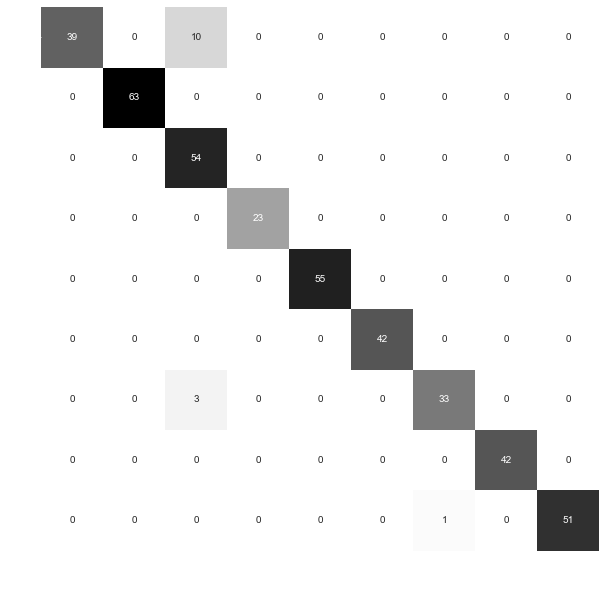

In [49]:
plot_cm(xception,test_ds)

In [50]:
train_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

val_ds = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=image_size,
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='rgb',
                                           batch_size=batch_size)

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


In [51]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 54
Number of test batches: 13


In [52]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
vgg_base = VGG19(include_top=False, weights= 'imagenet', input_shape=(128, 128, 3))
vgg_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [54]:
vgg_model = keras.models.Sequential()
vgg_model.add(Input(shape=image_size + (3,)))
vgg_model.add(Rescaling(1./255))
vgg_model.add(RandomFlip('horizontal_and_vertical'))
vgg_model.add(RandomRotation(0.2))
vgg_model.add(RandomZoom(0.1))
vgg_model.add(vgg_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(1024, activation='relu'))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(num_classes, activation='softmax'))

vgg_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_1 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
random_zoom_1 (RandomZoom)   (None, 128, 128, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)             

In [55]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

vgg_hist = vgg_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 37s 120ms/step - loss: 2.1317 - categorical_accuracy: 0.2758 - MCC: 0.1772 - F2: 0.2633 - auc: 0.7376 - prc: 0.3228 - val_loss: 2.1786 - val_categorical_accuracy: 0.2038 - val_MCC: 0.1725 - val_F2: 0.1495 - val_auc: 0.7099 - val_prc: 0.3018
Epoch 2/100
265/265 [==============================] - 29s 108ms/step - loss: 1.7136 - categorical_accuracy: 0.3118 - MCC: 0.2189 - F2: 0.3015 - auc: 0.7869 - prc: 0.3734 - val_loss: 1.8640 - val_categorical_accuracy: 0.3036 - val_MCC: 0.2352 - val_F2: 0.2481 - val_auc: 0.7657 - val_prc: 0.3660
Epoch 3/100
265/265 [==============================] - 31s 115ms/step - loss: 1.6679 - categorical_accuracy: 0.3322 - MCC: 0.2418 - F2: 0.3256 - auc: 0.8017 - prc: 0.4002 - val_loss: 1.5031 - val_categorical_accuracy: 0.3570 - val_MCC: 0.2888 - val_F2: 0.3152 - val_auc: 0.8427 - val_prc: 0.4575
Epoch 4/100
265/265 [==============================] - 29s 111ms/step - loss: 1.5753 - categorical_accuracy: 0.3

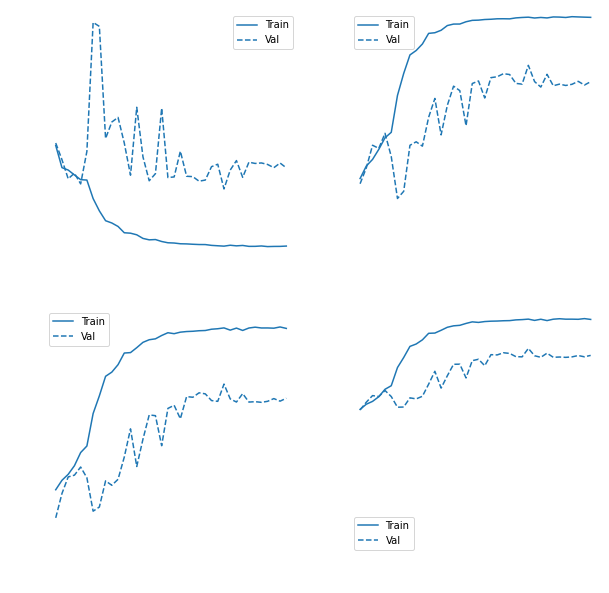

In [56]:
plot_metrics(vgg_hist)

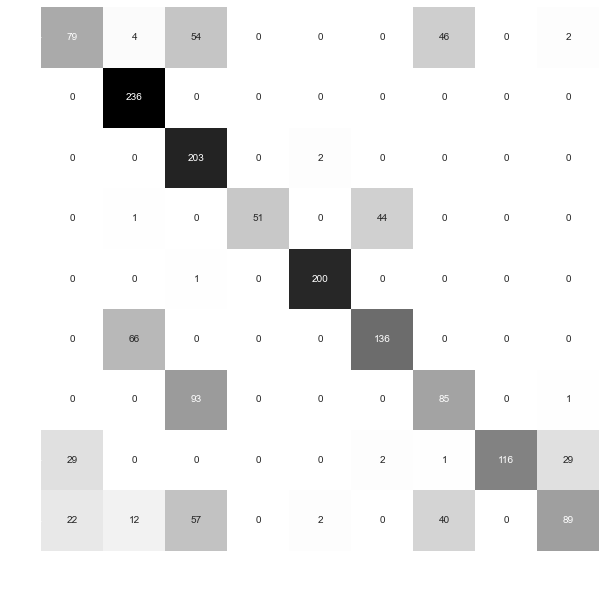

In [57]:
plot_cm(vgg_model, val_ds)

In [58]:
holdout_results(vgg_model)

13/13 [==============================] - 1s 51ms/step - loss: 1.4449 - categorical_accuracy: 0.6947 - MCC: 0.6630 - F2: 0.6796 - auc: 0.9168 - prc: 0.7672


{'loss': 1.444869875907898,
 'categorical_accuracy': 0.6947115659713745,
 'MCC': 0.6629713177680969,
 'F2': 0.6796478629112244,
 'auc': 0.9168151617050171,
 'prc': 0.7671741247177124}

In [60]:
image = keras.utils.load_img(
    path="C:\\Users\\nated\\Documents\\GitHub\\sar_target_recognition_deep_learning\\holdout_imgs\\t72_kuwait.jpg",
    color_mode='rgb',
    target_size=(128,128)
)

image

image_array = keras.utils.img_to_array(image)
image_array = tf.expand_dims(image_array, 0)

In [61]:
predict_t72(vgg_model)

'This image most likely belongs to 2S1 with a 24.61 percent confidence.'

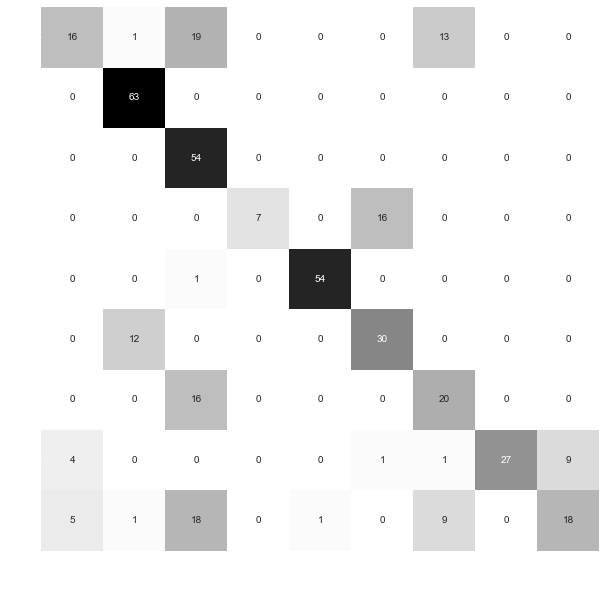

In [62]:
plot_cm(vgg_model,test_ds)

In [63]:
last_model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(image_size + (3,))),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.RandomFlip('horizontal_and_vertical'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.1),
  tf.keras.layers.Conv2D(128, 5, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 4, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 2, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])
last_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
random_flip_2 (RandomFlip)   (None, 128, 128, 3)       0         
_________________________________________________________________
random_rotation_2 (RandomRot (None, 128, 128, 3)       0         
_________________________________________________________________
random_zoom_2 (RandomZoom)   (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 124, 124, 128)     9728      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 59, 59, 64)       

In [64]:
last_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=metrics,)

last_model_hist = last_model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/100
265/265 [==============================] - 46s 158ms/step - loss: 1.6916 - categorical_accuracy: 0.3552 - MCC: 0.2685 - F2: 0.3454 - auc: 0.8054 - prc: 0.4155 - val_loss: 1.2491 - val_categorical_accuracy: 0.5044 - val_MCC: 0.4560 - val_F2: 0.4796 - val_auc: 0.9055 - val_prc: 0.6172
Epoch 2/100
265/265 [==============================] - 34s 130ms/step - loss: 1.1883 - categorical_accuracy: 0.5503 - MCC: 0.4907 - F2: 0.5464 - auc: 0.9099 - prc: 0.6341 - val_loss: 0.8231 - val_categorical_accuracy: 0.7041 - val_MCC: 0.6708 - val_F2: 0.6962 - val_auc: 0.9594 - val_prc: 0.7970
Epoch 3/100
265/265 [==============================] - 38s 145ms/step - loss: 0.8919 - categorical_accuracy: 0.6764 - MCC: 0.6338 - F2: 0.6746 - auc: 0.9500 - prc: 0.7677 - val_loss: 0.7834 - val_categorical_accuracy: 0.6941 - val_MCC: 0.6592 - val_F2: 0.6793 - val_auc: 0.9612 - val_prc: 0.8008
Epoch 4/100
265/265 [==============================] - 39s 146ms/step - loss: 0.7241 - categorical_accuracy: 0.7

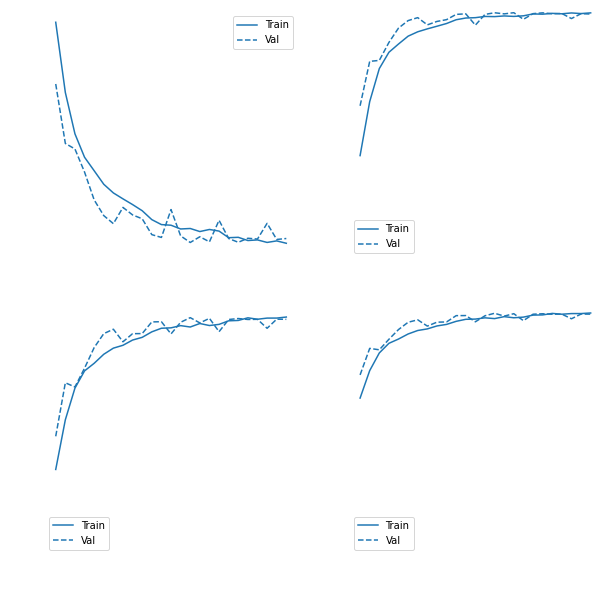

In [65]:
plot_metrics(last_model_hist)

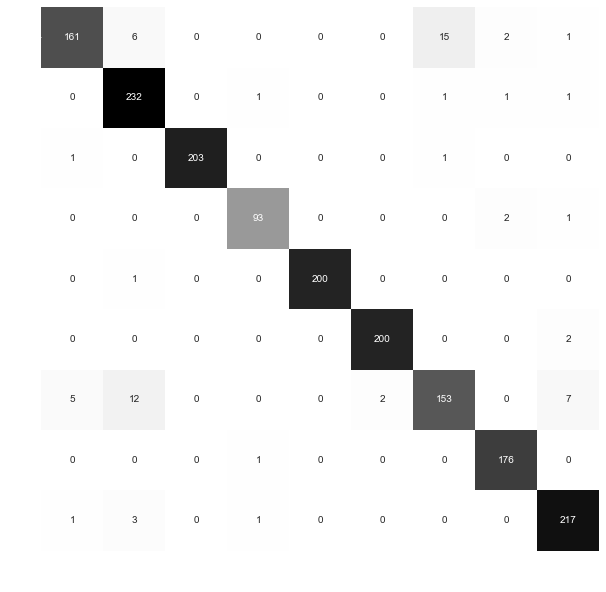

In [66]:
plot_cm(last_model, val_ds)

In [67]:
holdout_results(last_model)

13/13 [==============================] - 0s 24ms/step - loss: 0.1249 - categorical_accuracy: 0.9567 - MCC: 0.9511 - F2: 0.9568 - auc: 0.9979 - prc: 0.9921


{'loss': 0.12486802041530609,
 'categorical_accuracy': 0.9567307829856873,
 'MCC': 0.9511061310768127,
 'F2': 0.9567617774009705,
 'auc': 0.9978947043418884,
 'prc': 0.992051362991333}

In [68]:
predict_t72(last_model)

'This image most likely belongs to 2S1 with a 24.98 percent confidence.'

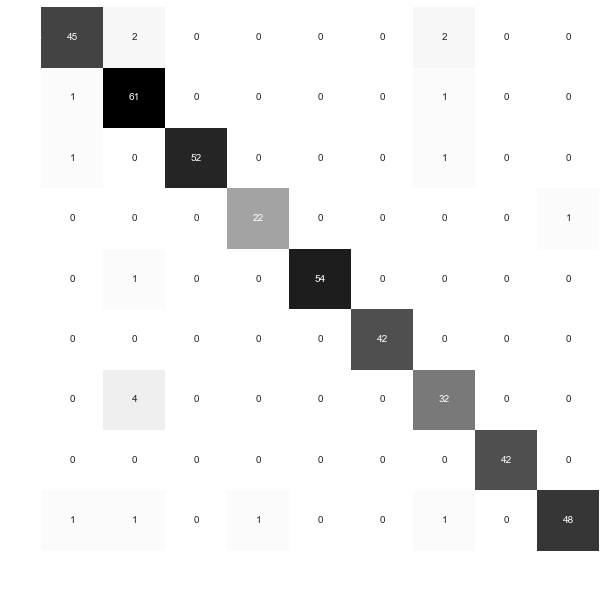

In [69]:
plot_cm(last_model, test_ds)